In [1]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from numpy.random import poisson, beta, uniform

import occSimFuncs as occFunc
from tvguide import TessPointing

from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline

In [2]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7.3}

In [10]:
# load the targets

fn2min = '../data/selectedreal6-Nominal-v1.csv.bz2'
fn = '/Users/tom/Dropbox/allCTL6-concat-v1.csv.bz2'

df = pd.read_csv(fn)

tics2min = pd.read_csv(fn2min, usecols=[13])

df.loc[:, 'Selected2min'] = np.isin(df.TICID, tics2min.TICID)


In [11]:
# some things we are going to need later
df['isMdwarf'] = np.where((df.TEFF < 3900) & (df.RADIUS < 0.5), True, False)
df['isGiant'] = np.ones(df.shape[0], dtype='bool') # assume all dwarfs

# per Pepper, a bunch of stars are actually subgiants, so fix this here
# 25% of FGK stars are actually subgiants
df['isSubgiant'] = np.where(np.random.random(size=df.shape[0]) < 0.25, True, False)
df.loc[df.isSubgiant & ~df.isMdwarf, 'RADIUS'] = df.RADIUS * 2

df['cosi'] = pd.Series(np.random.random(size=df.shape[0]),name='cosi')

df['noise_level'] = occFunc.component_noise(df.TESSMAG, readmod=1, zodimod=1)

df['nsectors'] = np.round(df.obs_len/27.4)

In [15]:
print('total stars = {}'.format(df[df.tess_ccd > 0].shape[0]))
print('total target slots = {}'.format(np.sum(df.obs_len) / 27.4))


print()
print('total stars 2min = {}'.format(df.loc[(df.tess_ccd > 0) & df.Selected2min].shape[0]))
print('total target slots 2min = {}'.format(np.sum(df.loc[df.Selected2min, 'obs_len']) / 27.4))


total stars = 3183343
total target slots = 5104790.000185879

total stars 2min = 212738
total target slots 2min = 418227.0000009818


In [16]:
# how many planets should each star get
np_fgk = poisson(lam=0.689,size=df.shape[0])
np_m = poisson(lam=2.5,size=df.shape[0])
df['Nplanets'] = pd.Series(np.where(df.isMdwarf, np_m, np_fgk), name='Nplanets')

In [17]:
# draw a bunch of planest and accociate them with each star
starID = 0 # ???
newDF, starID = occFunc.make_allplanets_df_vec(df, starID)

# get some transit epochs
newDF = newDF.assign(T0=pd.Series(uniform(0, 1, size=newDF.shape[0]) * newDF.loc[:, 'planetPeriod']))

#calculate the number of transits
nt1 = np.floor(newDF['obs_len'] / newDF.planetPeriod)
newDF['Ntransits'] = np.where(newDF['T0'] < newDF['obs_len'] % newDF.planetPeriod, nt1+1,nt1)
newDF['ars'] = occFunc.per2ars(newDF.planetPeriod, newDF.MASS, newDF.RADIUS)
newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius, newDF.RADIUS)
newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
newDF['duration'] = occFunc.get_duration(newDF.planetPeriod, newDF.ars, cosi=newDF.cosi, b=newDF.impact,
                                rprs=newDF.rprs) # cite Winn
newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius, newDF.RADIUS)

newDF['transit_depth_diluted']  = newDF['transit_depth'] / (1+newDF.CONTRATIO)

/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:28: RuntimeWarning: invalid value encountered in sqrt
  part3 = np.sqrt((1 + rprs)**2 - b**2)
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:30: RuntimeWarning: invalid value encountered in arcsin
  duration = part1 * np.arcsin(part2 * part3 / part4)


In [18]:
# now lets see if those planets are detected
newDF['needed_for_detection'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']

newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)

In [31]:
newDF['detected'] = ((newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & 
                     (newDF.planetRadius > 0.0) & newDF.has_transits)

newDF['detected2transits'] = ((newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 2) & 
                     (newDF.planetRadius > 0.0) & newDF.has_transits)


total_planets = newDF.detected.sum()
total_planets2transits = newDF.detected2transits.sum()

total_planets2min = newDF.loc[newDF.detected & newDF.Selected2min, 'detected'].sum()
total_planets2min2transits =newDF.loc[newDF.detected2transits & newDF.Selected2min, 'detected2transits'].sum()

In [32]:
print()
print('total_planets = {}'.format(total_planets))
print('total_planets 2transits = {}'.format(total_planets2transits))


print()
print('total_planets 2min = {}'.format(total_planets2min))
print('total_planets 2min 2transits = {}'.format(total_planets2min2transits))



total_planets = 3916
total_planets 2transits = 4559

total_planets 2min = 957
total_planets 2min 2transits = 1121


In [33]:
detected_DF = newDF[newDF.detected == True]

In [45]:
df = pd.read_csv(fn)
df_orig = df.copy()
tp = np.array([])
for x in tqdm(range(100)):
    df = df_orig.copy()
    # some things we are going to need later
    df['isMdwarf'] = np.where((df.TEFF < 3900) & (df.RADIUS < 0.5), True, False)
    df['isGiant'] = np.ones(df.shape[0], dtype='bool') # assume all dwarfs
    df['isSubgiant'] = np.where(np.random.random(size=df.shape[0]) < 0.25, True, False)
    df.loc[df.isSubgiant & ~df.isMdwarf, 'RADIUS'] = df.RADIUS * 2
    
    df['cosi'] = pd.Series(np.random.random(size=df.shape[0]),name='cosi')

    df['noise_level'] = occFunc.component_noise(df.TESSMAG, readmod=1, zodimod=1)
    # how many planets should each star get
    np_fgk = poisson(lam=0.689,size=df.shape[0])
    np_m = poisson(lam=2.5,size=df.shape[0])
    df['Nplanets'] = pd.Series(np.where(df.isMdwarf, np_m, np_fgk), name='Nplanets')
    # draw a bunch of planest and accociate them with each star
    starID = 0 # ???
    newDF, starID = occFunc.make_allplanets_df_vec(df, starID)

    # get some transit epochs
    newDF = newDF.assign(T0=pd.Series(uniform(0, 1, size=newDF.shape[0]) * newDF.loc[:, 'planetPeriod']))

    #calculate the number of transits
    nt1 = np.floor(newDF['obs_len'] / newDF.planetPeriod)
    newDF['Ntransits'] = np.where(newDF['T0'] < newDF['obs_len'] % newDF.planetPeriod, nt1+1,nt1)
    newDF['ars'] = occFunc.per2ars(newDF.planetPeriod, newDF.MASS, newDF.RADIUS)
    newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
    newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
    newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius, newDF.RADIUS)
    newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
    newDF['duration'] = occFunc.get_duration(newDF.planetPeriod, newDF.ars, cosi=newDF.cosi, b=newDF.impact,
                                    rprs=newDF.rprs) # cite Winn
    newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
    newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius, newDF.RADIUS)

    newDF['transit_depth_diluted']  = newDF['transit_depth'] / (1+newDF.CONTRATIO)
    # now lets see if those planets are detected
    newDF['needed_for_detection'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                        np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']

    newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)
    newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits


    total_planets = newDF.detected.sum()
    tp = np.r_[tp,total_planets]
    if total_planets == 3870:
        break


  0%|          | 0/100 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/tom/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/tom/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/tom/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:28: RuntimeWarning: invalid value encountered in sqrt
  part3 = np.sqrt((1 +

In [46]:
np.mean(tp), np.min(tp), np.max(tp), np.median(tp)

(3849.375, 3707.0, 3993.0, 3856.0)

In [47]:
detected_DF = newDF[newDF.detected == True]

In [48]:
detected_DF.shape

(3870, 41)

In [51]:
newDF.loc[:, 'Selected2min'] = np.isin(newDF.TICID, tics2min.TICID)

newDF.to_csv('../data/fiducial6-ffis.csv.bz2', compression='bz2')
newDF.loc[newDF.Selected2min].to_csv('../data/fiducial6-2min.csv.bz2', compression='bz2')

In [26]:
['{}: {} & {} & {}'.format(x,*np.percentile(detected_DF.loc[:,x], [50,5,95], axis=0)) for x in detected_DF.columns]

['Unnamed: 0: 1891781.0 & 235261.1 & 3427702.399999998',
 'RA: 201.30198741400002 & 27.935713219420002 & 325.531588013',
 'DEC: 19.3226786947 & -74.75192642405 & 76.53638993717',
 'TESSMAG: 10.582 & 7.419700000000001 & 13.5441',
 'TEFF: 5484.0 & 3177.1 & 7069.899999999999',
 'PRIORITY: 0.0034861029350900003 & 0.001913473440986 & 0.014651877175489979',
 'RADIUS: 0.970591 & 0.22970000000000002 & 2.0138619999999996',
 'MASS: 0.964105 & 0.2064 & 1.6050672788639997',
 'CONTRATIO: 0.0123467871515 & 0.00010423242917560001 & 0.23662168538329917',
 'ECLONG: 177.72351666 & 14.279374801000001 & 336.51723381399995',
 'ECLAT: 19.171331 & -79.184824029 & 81.73588741699999',
 'V: 11.427 & 7.947 & 16.4665',
 'Ks: 9.397 & 6.613 & 11.164299999999999',
 'TICID: 237255601.0 & 26155626.200000003 & 439112956.3999999',
 'SELECTED: 1.0 & 1.0 & 1.0',
 'tess_ccd: 3.0 & 1.0 & 4.0',
 'obs_len: 54.8 & 27.4 & 356.2',
 'isMdwarf: 0.0 & 0.0 & 1.0',
 'isGiant: 1.0 & 1.0 & 1.0',
 'cosi: 0.023626856303810118 & 0.0023522

In [27]:
# duration = 0.08409320732236308*24, 0.03254344397594473*24, 0.21720016184307991*24
np.percentile(detected_DF.loc[:,'duration'], [50,5,95], axis=0) * 24

array([ 2.78735762,  0.90793073,  7.43663289])

In [28]:
np.percentile(detected_DF.needed_for_detection * 7.3 / detected_DF.noise_level, [50,5,95])

array([  14.14575869,    7.69372917,  155.91482964])

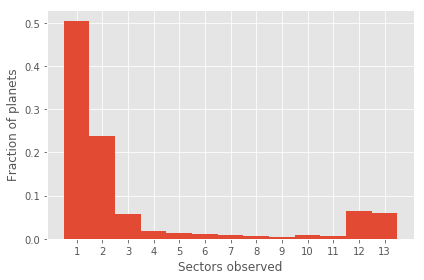

In [35]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1)
    ax.hist(detected_DF.obs_len / 27.4, bins=np.arange(0.5,14.5,1), cumulative=False, normed=True)
    ax.set_xlabel('Sectors observed')
    ax.set_ylabel('Fraction of planets')
    ax.xaxis.set_ticks(range(1,14,1))
#     ax.xaxis.set_ticklabels(range(1,14,1))
    fig.tight_layout()
    fig.savefig('../plots/obs_len_ffi.png', dpi=200)

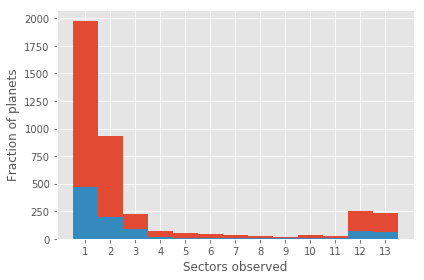

In [40]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1)
    ax.hist(detected_DF.obs_len / 27.4, bins=np.arange(0.5,14.5,1), cumulative=False, normed=False)
    ax.hist(detected_DF.loc[detected_DF.Selected2min, 'obs_len'] / 27.4, 
            bins=np.arange(0.5,14.5,1), cumulative=False, normed=False)
    ax.set_xlabel('Sectors observed')
    ax.set_ylabel('Fraction of planets')
    ax.xaxis.set_ticks(range(1,14,1))
#     ax.xaxis.set_ticklabels(range(1,14,1))
    fig.tight_layout()
    fig.savefig('../plots/obs_len_ffi.png', dpi=200)

/Users/tom/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


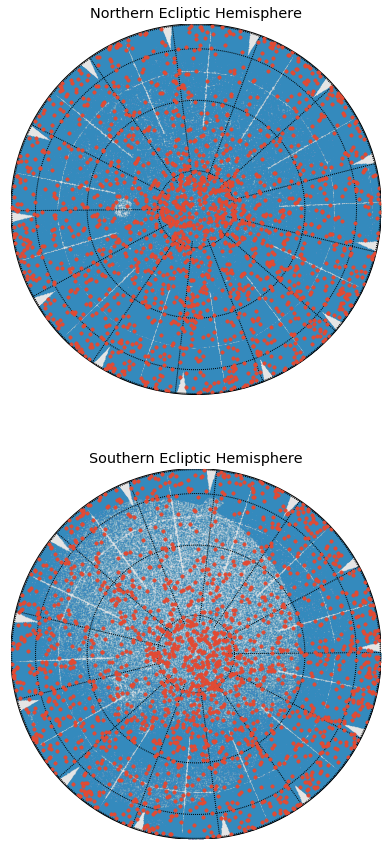

In [41]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('ggplot'):
    fig, [ax1, ax2] = plt.subplots(2,1, figsize=[15,15])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax1)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].ECLONG.values, newDF[newDF.tess_ccd > 0].ECLAT.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax2)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].ECLONG.values, newDF[newDF.tess_ccd > 0].ECLAT.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax1.set_title('Northern Ecliptic Hemisphere')
    ax2.set_title('Southern Ecliptic Hemisphere')

/Users/tom/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


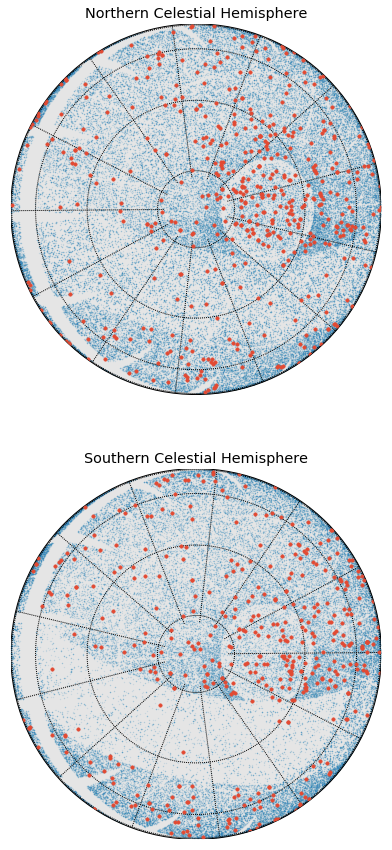

In [78]:
from mpl_toolkits.basemap import Basemap
with plt.style.context('ggplot'):
    fig, [ax1, ax2] = plt.subplots(2,1, figsize=[15,15])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax1)
    m.scatter(detected_DF.RA.values, detected_DF.DEC.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].RA.values, newDF[newDF.tess_ccd > 0].DEC.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax2)
    m.scatter(detected_DF.RA.values, detected_DF.DEC.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].RA.values, newDF[newDF.tess_ccd > 0].DEC.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax1.set_title('Northern Celestial Hemisphere')
    ax2.set_title('Southern Celestial Hemisphere')

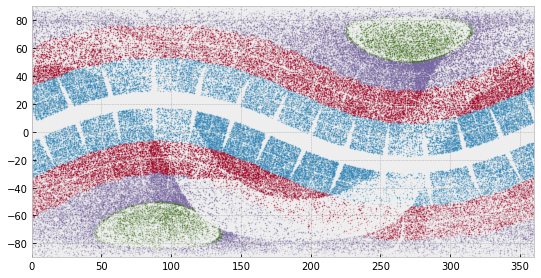

In [79]:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(1,1, figsize=[9,9])
    ax.scatter(newDF[newDF.tess_ccd == 1].RA, newDF[newDF.tess_ccd ==1].DEC, s=1, alpha=0.1)
    ax.scatter(newDF[newDF.tess_ccd == 2].RA, newDF[newDF.tess_ccd ==2].DEC, s=1, alpha=0.1)
    ax.scatter(newDF[newDF.tess_ccd == 3].RA, newDF[newDF.tess_ccd ==3].DEC, s=1, alpha=0.1)
    ax.scatter(newDF[newDF.tess_ccd == 4].RA, newDF[newDF.tess_ccd ==4].DEC, s=1, alpha=0.1)
    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.set_aspect('equal')

/Users/tom/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


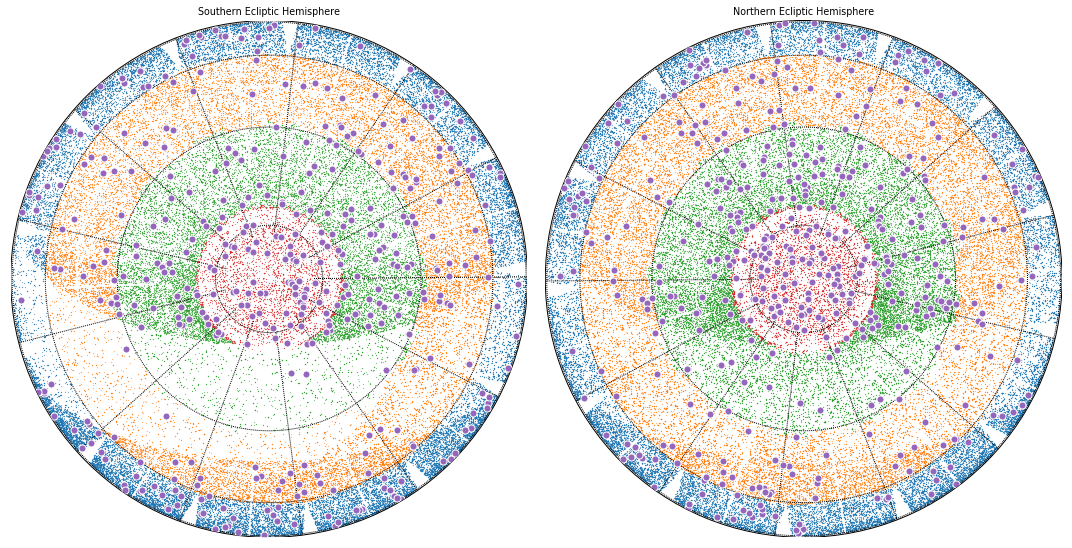

In [80]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=[15,8])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax2)
    m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=50, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1)
    m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
              s=50, alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax2.set_title('Northern Ecliptic Hemisphere')
    ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
    fig.savefig('../plots/skyplot.png', dpi=200)

In [25]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=[15,8])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax2)
    m.scatter(newDF.ECLONG.values[newDF. == 27.4], newDF.ECLAT.values[newDF.obs_len == 27.4], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*2], newDF.ECLAT.values[newDF.obs_len == 27.4*2], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*3], newDF.ECLAT.values[newDF.obs_len == 27.4*3], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len > 27.4*3], newDF.ECLAT.values[newDF.obs_len > 27.4*3], 
              s=1, alpha=0.5, latlon=True)

    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=50, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4], newDF.ECLAT.values[newDF.obs_len == 27.4], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*2], newDF.ECLAT.values[newDF.obs_len == 27.4*2], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*3], newDF.ECLAT.values[newDF.obs_len == 27.4*3], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len > 27.4*3], newDF.ECLAT.values[newDF.obs_len > 27.4*3], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
              s=50, alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax2.set_title('Northern Ecliptic Hemisphere')
    ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
#     fig.savefig('../plots/skyplot.png', dpi=200)

SyntaxError: invalid syntax (<ipython-input-25-4564cfc596f1>, line 6)

In [ ]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1,1, figsize=[15,8])
    m = Basemap(projection='gall', resolution='l', celestial=True, ax=ax)
#     m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=50, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    m.scatter(newDF.ECLONG.values, newDF.ECLAT.values, 
              s=1, alpha=0.5, latlon=True, c=newDF.obs_len.values, vmin=0, vmax=27.4*2)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

#     m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1)
#     m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
#               s=50, alpha=1, latlon=True, zorder=100)
#     parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
#     m.drawparallels(parallels, latmax=78, latmin=-78)
#     meridians = np.linspace(240-12,360+240-12,14)[:-1]
#     m.drawmeridians(meridians,)
#     ax2.set_title('Northern Ecliptic Hemisphere')
#     ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
#     fig.savefig('../plots/skyplot.png', dpi=200)

In [ ]:
plt.scatter(newDF.ECLAT, newDF.obs_len)
plt.xlim(50,78)

In [4]:
import numpy as np

In [7]:
np.isin(np.arange(100), np.array([1,3,6]), )

array([False,  True, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [4]:
np.isin(df.TICID, tics2min.TICID)

AttributeError: 'DataFrame' object has no attribute 'TICID'

In [8]:
tics2min = pd.read_csv(fn2min, usecols=[13])

df.loc[:, 'Selected2min'] = np.isin(df.TICID, tics2min.TICID)

In [27]:
newDF.loc[newDF.detected & newDF.Selected2min, 'detected'].sum()

957

In [49]:
newDF.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'RA', 'DEC', 'TESSMAG', 'TEFF',
       'PRIORITY', 'RADIUS', 'MASS', 'CONTRATIO', 'ECLONG', 'ECLAT', 'V', 'Ks',
       'TICID', 'SELECTED', 'tess_ccd', 'obs_len', 'isMdwarf', 'isGiant',
       'isSubgiant', 'cosi', 'noise_level', 'Nplanets', 'planetRadius',
       'planetPeriod', 'starID', 'T0', 'Ntransits', 'ars', 'ecc', 'omega',
       'rprs', 'impact', 'duration', 'duration_correction', 'transit_depth',
       'transit_depth_diluted', 'needed_for_detection', 'has_transits',
       'detected'],
      dtype='object')